# Regression example with a neural network

## Prepare data

In [36]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [37]:
with gzip.open("rec_hist_pt_25.pkl.gz") as f:
    rec = pickle.load(f)

with gzip.open("gen_hist_pt_25.pkl.gz") as f:
    gen = pickle.load(f)

# fix for divide by zero
gen.values()[gen.values() == 0] = 1

n_gen = gen.values()
n_rec = rec.values()
# fix for rec > n
n_rec = np.where(n_rec > n_gen, n_gen, n_rec)

X = []
data_k = []
data_n = []
for ieta, eta in enumerate(rec.axes[0].centers):
    for ipt, pt in enumerate(rec.axes[1].centers):
        for iphi, phi in enumerate(rec.axes[2].centers):
            for ich, _ in enumerate(rec.axes[3]):
                for isp, _ in enumerate(rec.axes[4]):
                    X.append((eta, np.log(pt), np.cos(phi), np.sin(phi), ich, isp))
                    data_k.append(n_rec[ieta, ipt, iphi, ich, isp])
                    data_n.append(n_gen[ieta, ipt, iphi, ich, isp])

X0 = np.array(X).astype(np.float32)
data_k = np.array(data_k).astype(np.float32)
data_n = np.array(data_n).astype(np.float32)
y = data_k / data_n

scaler = StandardScaler()
scaler.fit(X0)

X = scaler.transform(X0)

print("data points", X.shape[0])

data points 14400


In [38]:
def draw(model):
    labels = ("π", "K", "p", "other")
    for phii in rec.axes[2].centers[:]:
        if phii < 0:
            continue
        fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, layout="compressed")
        plt.suptitle(rf"$\phi = {np.degrees(phii):.0f}$ deg")
        for etai, axi in zip(rec.axes[0].centers, axes.flat):
            plt.sca(axi)
            for ich, charge in enumerate((-1, 1)):
                for isp, label in enumerate(labels):
                    ma = X0[:, 0] == etai
                    ma &= X0[:, 2] == np.cos(phii)
                    ma &= X0[:, 3] == np.sin(phii)
                    ma &= X0[:, 4] == ich
                    ma &= X0[:, 5] == isp
                    plt.plot(np.exp(X0[ma, 1]), charge * y[ma], "o", ms=4, color=f"C{isp}", label=f"{label}" if ich else None)

                    mpt = np.geomspace(10, 1e4, 2000)
                    Xp = np.empty((len(mpt), 6), dtype=np.float32)
                    Xp[:, 0] = etai
                    Xp[:, 1] = np.log(mpt)
                    Xp[:, 2] = np.cos(phii)
                    Xp[:, 3] = np.sin(phii)
                    Xp[:, 4] = ich
                    Xp[:, 5] = isp
                    yp = model(scaler.transform(Xp))
                    plt.plot(np.exp(Xp[:, 1]), charge * yp, color=f"C{isp}")
        plt.sca(axes[0,0])
        plt.semilogx()
        plt.ylim(-1.1, 1.1)
        plt.legend(fontsize="xx-small", ncol=2, frameon=False);

## Scikit-Learn

It turns out that the simple MLPRegressor in Scikit-Learn works very well on small datasets.

In [39]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

clf = MLPRegressor(
    hidden_layer_sizes=(2**6,) * 4,
    batch_size=1000,
    alpha=0,
    tol=1e-6,
    max_iter=1000,
    verbose=1,
)

clf.fit(X, y)

# coefficients only available after training
n = 0
for c in clf.coefs_:
    n += np.prod(c.shape)
for c in clf.intercepts_:
    n += c.shape[0]
print("number of parameters", n)

print("MLPRegressor", mean_squared_error(clf.predict(X), y))

Iteration 1, loss = 0.06895166
Iteration 2, loss = 0.02507499
Iteration 3, loss = 0.01745829
Iteration 4, loss = 0.01334149
Iteration 5, loss = 0.01047026
Iteration 6, loss = 0.00822828
Iteration 7, loss = 0.00670404
Iteration 8, loss = 0.00569793
Iteration 9, loss = 0.00496255
Iteration 10, loss = 0.00434982
Iteration 11, loss = 0.00384218
Iteration 12, loss = 0.00342440
Iteration 13, loss = 0.00309772
Iteration 14, loss = 0.00283313
Iteration 15, loss = 0.00261945
Iteration 16, loss = 0.00245801
Iteration 17, loss = 0.00231077
Iteration 18, loss = 0.00217783
Iteration 19, loss = 0.00210065
Iteration 20, loss = 0.00202444
Iteration 21, loss = 0.00197935
Iteration 22, loss = 0.00195885
Iteration 23, loss = 0.00184591
Iteration 24, loss = 0.00175889
Iteration 25, loss = 0.00172785
Iteration 26, loss = 0.00165073
Iteration 27, loss = 0.00160580
Iteration 28, loss = 0.00155256
Iteration 29, loss = 0.00151164
Iteration 30, loss = 0.00148649
Iteration 31, loss = 0.00146052
Iteration 32, los

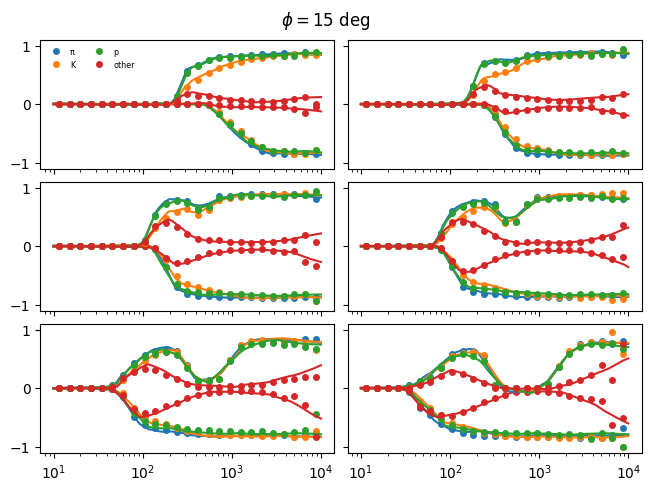

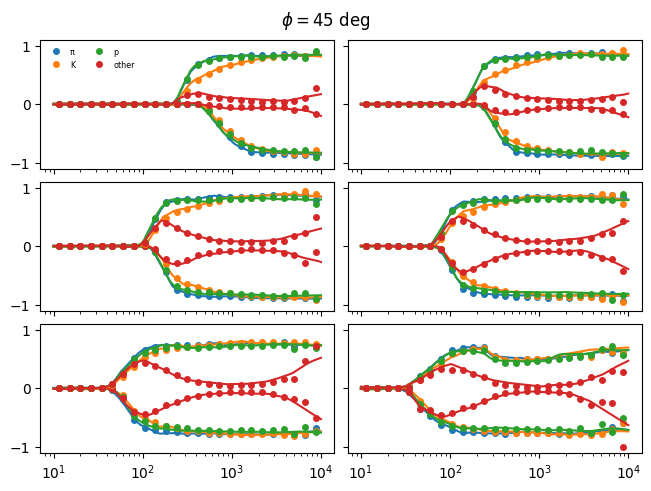

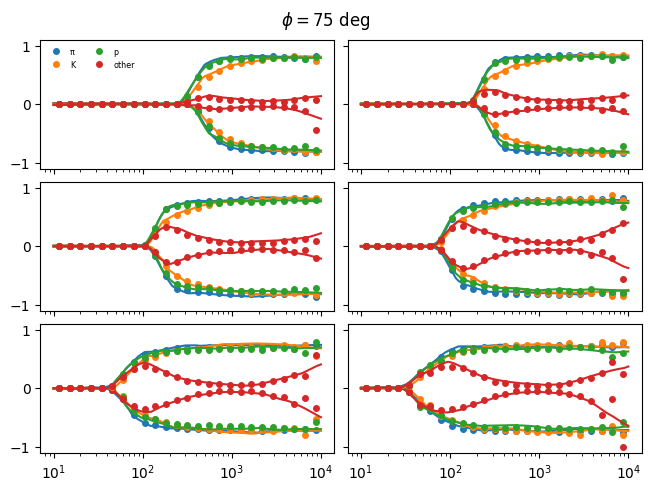

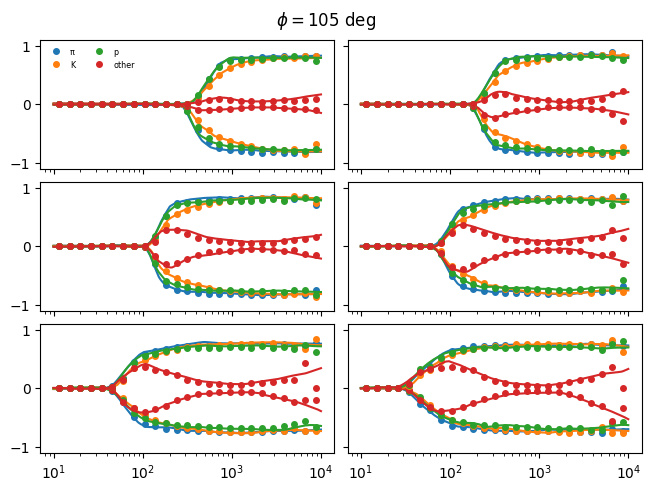

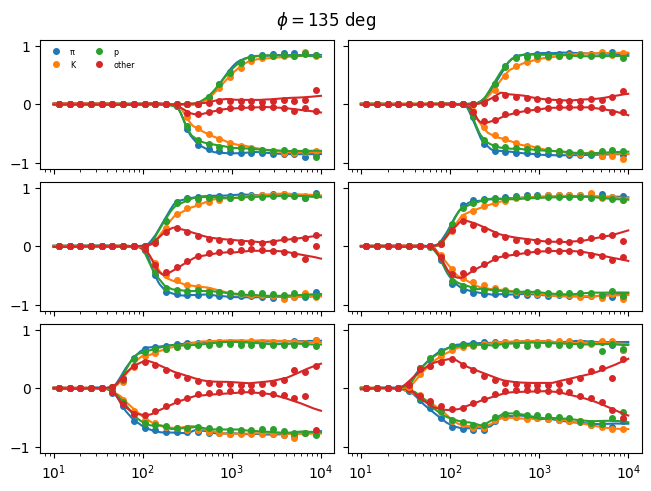

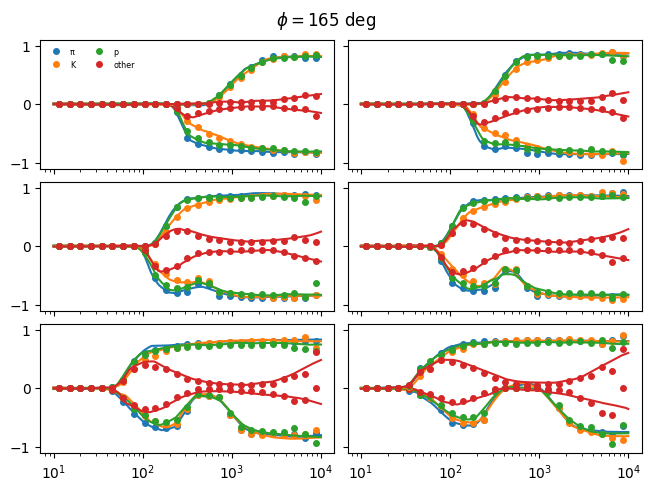

In [40]:
draw(clf.predict)

## PyTorch

number of parameters 12993
epoch 1 loss 0.29075366258621216
epoch 100 loss 0.014033177867531776
epoch 200 loss 0.0045087323524057865
epoch 300 loss 0.0026419605128467083
epoch 400 loss 0.001992984674870968
epoch 500 loss 0.0016699167899787426
Epoch 00538: reducing learning rate of group 0 to 8.0000e-04.
epoch 600 loss 0.0014954190701246262
epoch 700 loss 0.0013842129847034812
Epoch 00711: reducing learning rate of group 0 to 6.4000e-04.
epoch 800 loss 0.0013144537806510925
Epoch 00899: reducing learning rate of group 0 to 5.1200e-04.
epoch 900 loss 0.0012641609646379948
epoch 1000 loss 0.0012197608593851328
epoch 1100 loss 0.0011834448669105768
Epoch 01128: reducing learning rate of group 0 to 4.0960e-04.
epoch 1200 loss 0.0011497314553707838
epoch 1300 loss 0.0011222076136618853
Epoch 01380: reducing learning rate of group 0 to 3.2768e-04.
epoch 1400 loss 0.001097456319257617
epoch 1500 loss 0.0010776997078210115
epoch 1600 loss 0.0010583593975752592
epoch 1700 loss 0.0010401959298178

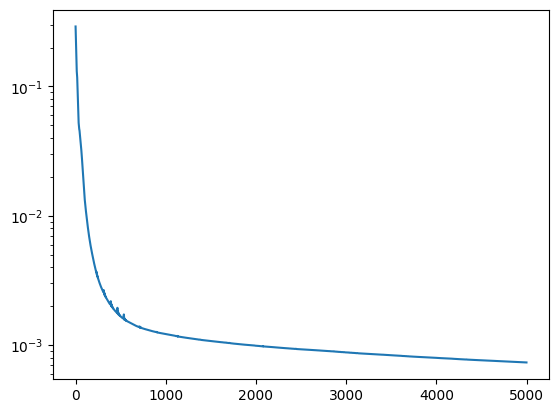

In [41]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

nonlin = nn.ReLU()
num = 2**6
torch_model = nn.Sequential(
    nn.Linear(6, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, 1),
    # adding a ReLU here makes training unstable
    nn.Flatten(0, 1),
)

n = 0
for par in torch_model.parameters():
    n += np.prod(par.shape)
print("number of parameters", n)

# must make copies here
torch_X = torch.tensor(X.copy())
torch_y = torch.tensor(y.copy())

max_epoch = 5000
shrink_patience = 10
abort_patience = 100
learning_rate = 1e-3
learning_rate_shrink_factor = 0.8
tol = 1e-6

loss_fn = nn.MSELoss()
opt = Adam(torch_model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(
    opt, patience=shrink_patience, factor=learning_rate_shrink_factor, verbose=True
)

losses = []
no_improvement_below_tolerance = 0
prev_loss = np.inf
for epoch in range(1, max_epoch + 1):
    y_pred = torch_model(torch_X)
    loss = loss_fn(y_pred, torch_y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    loss = loss.item()
    losses.append(loss)
    if epoch == 1 or epoch % 100 == 0:
        print("epoch", epoch, "loss", loss)

    if loss < prev_loss - tol:
        no_improvement_below_tolerance = 0
        prev_loss = loss
    else:
        no_improvement_below_tolerance += 1
    if no_improvement_below_tolerance > abort_patience:
        break

plt.plot(losses)
plt.semilogy();

In [42]:
print("MLPRegressor", mean_squared_error(clf.predict(X), y))
print("PyTorch     ", mean_squared_error(torch_model(torch_X).detach().numpy(), y))

MLPRegressor 0.0010770992
PyTorch      0.00073587627


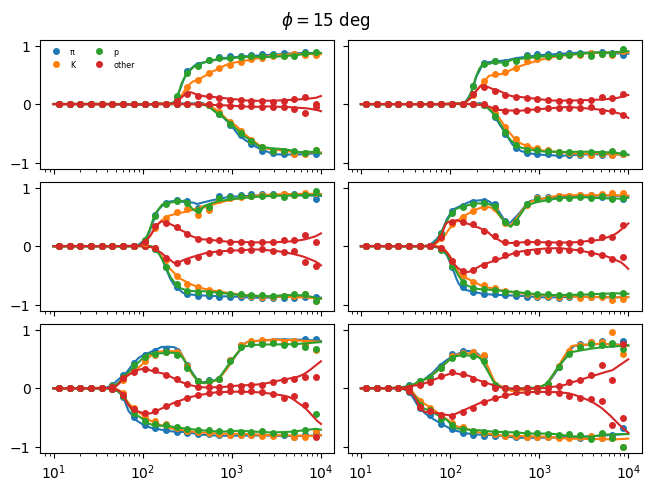

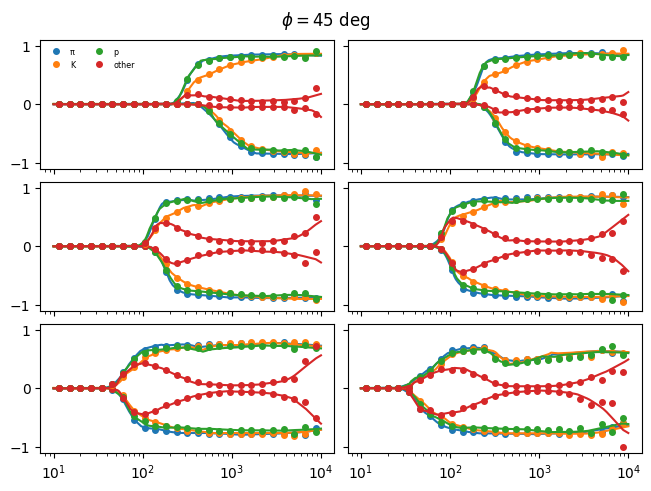

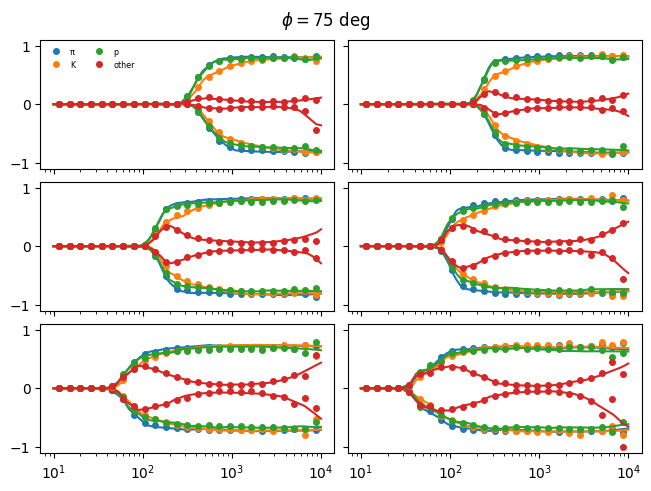

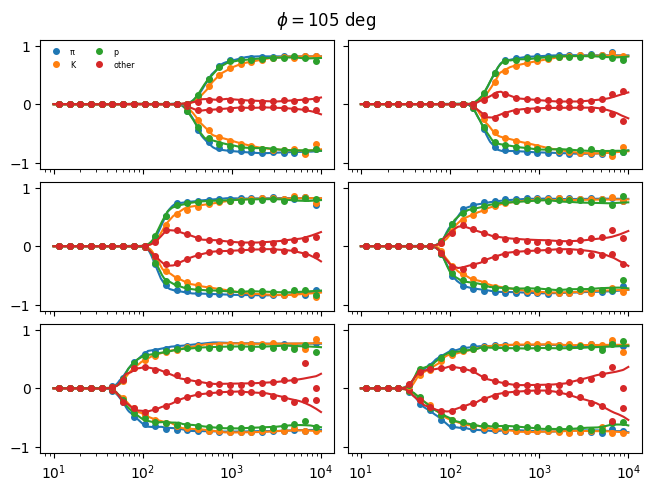

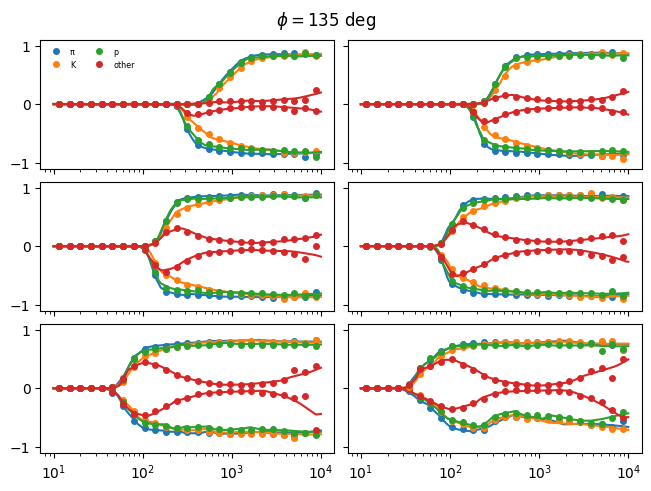

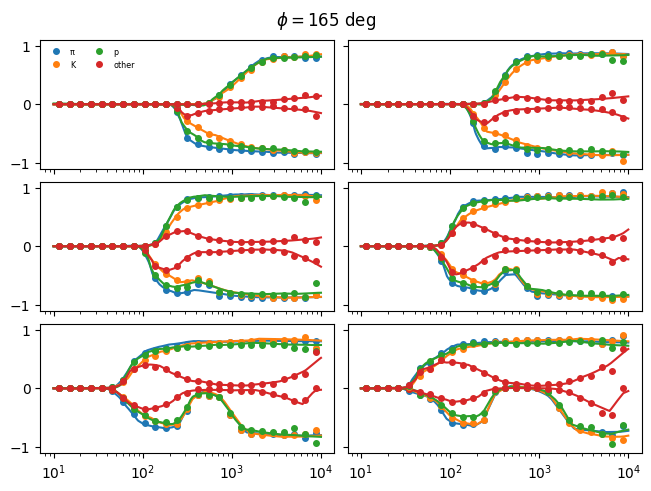

In [43]:
draw(lambda x: torch_model(torch.tensor(x)).detach().numpy())

## Flax / JAX

Flax with JAX is a modern functional programming library which is great for trying out new things. It comes with fewer high-level functionality than PyTorch. Where PyTorch offers ReduceLROnPlateau, we need to implement something analog from scratch.

JAX process: 0 / 1
JAX local devices: [CpuDevice(id=0)]
number of parameters 12993
epoch 1 loss=0.1615249365568161
epoch 100 loss=0.004056446719914675
epoch 200 loss=0.0022707092575728893
epoch 237 learning rate=0.00800000037997961
epoch 247 learning rate=0.006400000303983688
epoch 300 loss=0.0015574624994769692
epoch 400 loss=0.0013330463552847505
epoch 500 loss=0.0012052441015839577
epoch 600 loss=0.0011462707770988345
epoch 604 learning rate=0.005120000336319208
epoch 700 loss=0.0010661932174116373
epoch 773 learning rate=0.0040960004553198814
epoch 800 loss=0.0010216122027486563
epoch 900 loss=0.0009868466295301914
epoch 982 learning rate=0.0032768005039542913
epoch 1000 loss=0.0009563774801790714
epoch 1100 loss=0.0009271150338463485
epoch 1200 loss=0.0008946977904997766
epoch 1256 learning rate=0.002621440449729562
epoch 1300 loss=0.0008701515616849065
epoch 1400 loss=0.0008422626415267587
epoch 1500 loss=0.0008212537504732609
epoch 1600 loss=0.0008094692602753639
epoch 1602 lear

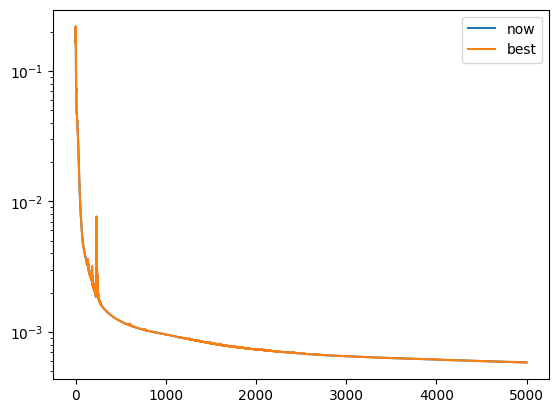

In [44]:
from typing import Callable, Iterable
from types import SimpleNamespace
import jax
from jax import numpy as jnp
from flax import linen as nn
import optax


class Model(nn.Module):
    sizes: Iterable[int]  # Number of hidden neurons
    nonlin: Callable

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        for size in self.sizes:
            x = nn.Dense(size)(x)
            x = self.nonlin(x)
        return nn.Dense(1)(x).flatten()


def train(config: SimpleNamespace, x, y):
    x = jax.device_put(x)
    y = jax.device_put(y)

    model = Model(config.layers, config.nonlin)

    @jax.jit
    def loss_fn(theta, x, y):
        def squared_error(x, y):
            y_pred = model.apply(theta, x)
            return jnp.square(y - y_pred)
        return jnp.mean(jax.vmap(squared_error, in_axes=0)(x, y))

    key1, key2 = jax.random.split(jax.random.PRNGKey(0))
    theta = model.init(key2, jax.random.normal(key1, x.shape[1:]))

    n = 0
    for layer in theta["params"].values():
        n += np.prod(layer["kernel"].shape) + layer["bias"].shape[0]
    print("number of parameters", n)

    tx = optax.inject_hyperparams(lambda learning_rate: optax.chain(
        optax.clip(1),  # equivalent to using huber loss
        optax.adabelief(learning_rate),
    ))(learning_rate=config.learning_rate)
    tx_state = tx.init(theta)
    loss_grad_fn = jax.value_and_grad(loss_fn)

    losses = []
    prev_loss = np.inf
    epochs_without_improvement = 0
    for epoch in range(1, config.max_epoch + 1):

        loss, grads = loss_grad_fn(theta, x, y)
        updates, tx_state = tx.update(grads, tx_state)
        theta = optax.apply_updates(theta, updates)

        losses.append(loss)

        if epoch == 1 or epoch % config.print_freq == 0:
            print(f"epoch {epoch} loss={loss}")

        if loss < prev_loss:
            epochs_without_improvement = 0
            prev_loss = loss
        else:
            epochs_without_improvement += 1
        if epochs_without_improvement >= config.shrink_patience:
            tx_state.hyperparams["learning_rate"] *= config.learning_rate_shrink_factor
            print(f"epoch {epoch } learning rate={tx_state.hyperparams['learning_rate']}")
            epochs_without_improvement = 0
            continue
        if tx_state.hyperparams["learning_rate"] < config.tolerance:
            break

    return model, theta, losses

print(f"JAX process: {jax.process_index()} / {jax.process_count()}")
print(f"JAX local devices: {jax.local_devices()}")

config = SimpleNamespace()
config.layers = (2 ** 6,) * 4
config.nonlin = nn.relu
config.max_epoch = 5000
config.learning_rate = 1e-2
config.shrink_patience = 10
config.learning_rate_shrink_factor = 0.8
config.print_freq = 100
config.tolerance = 1e-6

prev_losses = locals().get("prev_losses", None)

flax_model, flax_theta, losses = train(config, X, y)

best_losses = locals().get("best_losses", losses)
if best_losses[-1] < losses[-1]:
    best_losses = losses

plt.plot(losses, label="now")
if prev_losses is not None:
    plt.plot(prev_losses, label="previous")
plt.plot(best_losses, label="best")
plt.legend()
plt.semilogy();

In [45]:
print("MLPRegressor", mean_squared_error(clf.predict(X), y))
print("PyTorch     ", mean_squared_error(torch_model(torch_X).detach().numpy(), y))
print("Flax        ", mean_squared_error(flax_model.apply(flax_theta, X), y))

MLPRegressor 0.0010770992
PyTorch      0.00073587627
Flax         0.0005836923


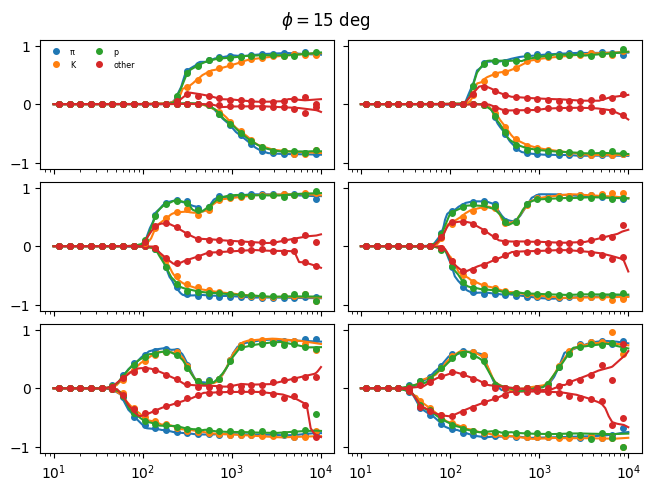

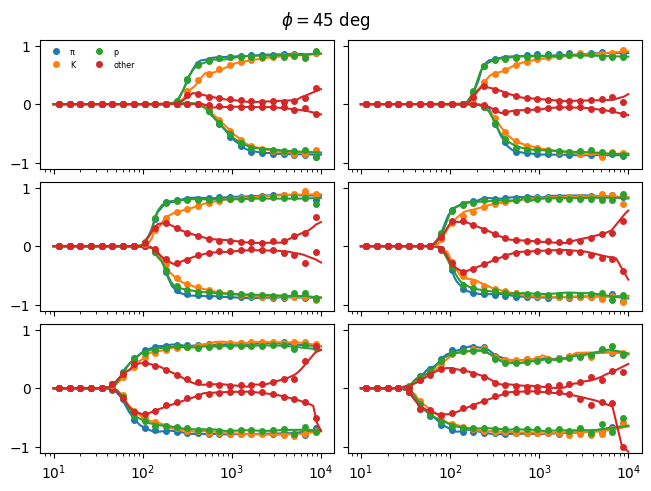

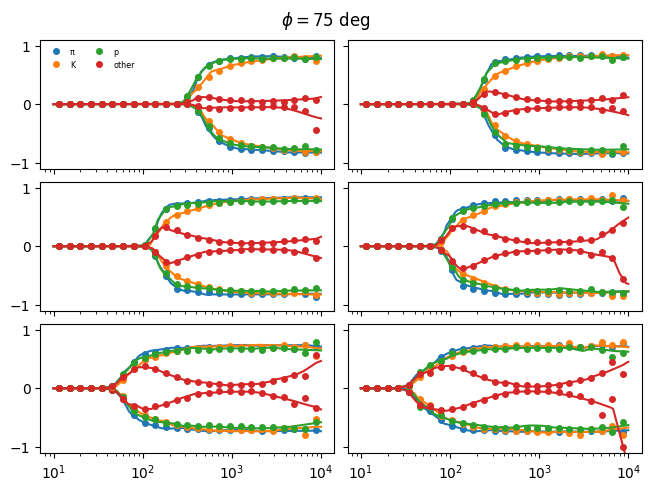

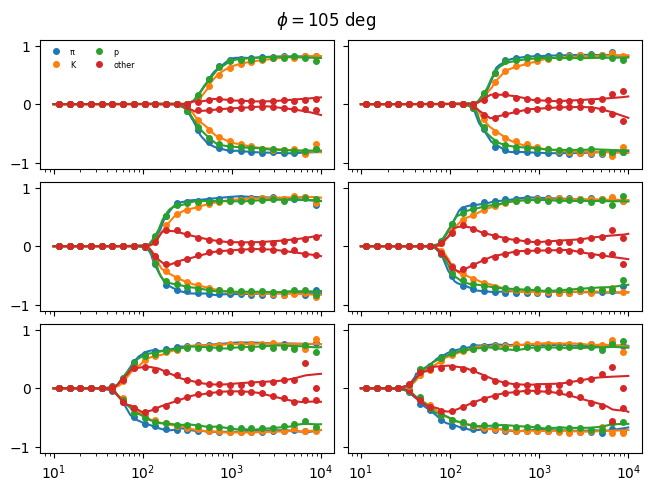

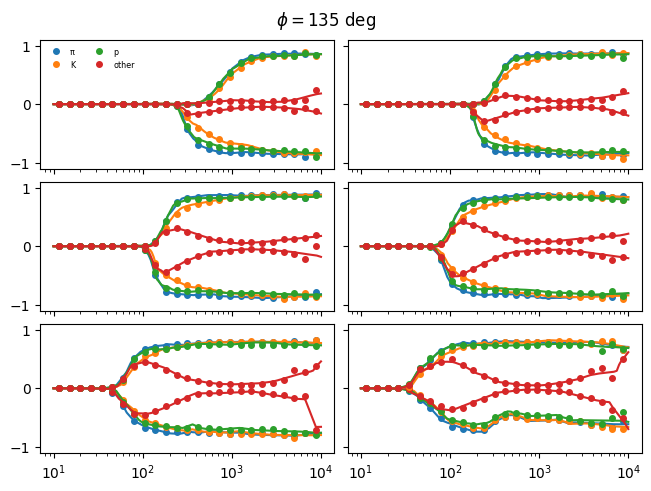

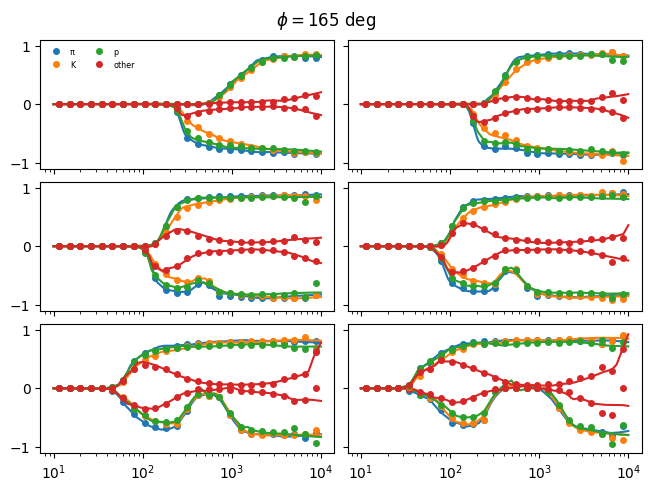

In [46]:
draw(lambda x: flax_model.apply(flax_theta, x))

Another version of learning with FLAX using the meta-learning technique, where the learning rate of the model optimization is learned by an outer learning step. Meta-learning outperforms our previous approach: the loss after 5000 epochs is smaller, and the run-time is a bit shorter.

epoch 1 loss=0.31326305866241455 lr=0.00970732606947422
epoch 100 loss=0.022382477298378944 lr=0.008342958986759186
epoch 200 loss=0.009440391324460506 lr=0.008291025646030903
epoch 300 loss=0.005982980597764254 lr=0.008259016089141369
epoch 400 loss=0.004722251556813717 lr=0.008235295303165913
epoch 500 loss=0.0026633746456354856 lr=0.008185734041035175
epoch 600 loss=0.0032396698370575905 lr=0.008146436884999275
epoch 700 loss=0.002778511494398117 lr=0.008116255514323711
epoch 800 loss=0.003227198962122202 lr=0.00809383299201727
epoch 900 loss=0.0033369455486536026 lr=0.008060149848461151
epoch 1000 loss=0.0021190992556512356 lr=0.008024145849049091
epoch 1100 loss=0.002638544887304306 lr=0.007992972619831562
epoch 1200 loss=0.002345192711800337 lr=0.007957393303513527
epoch 1300 loss=0.001486414228565991 lr=0.007931879721581936
epoch 1400 loss=0.0017564770532771945 lr=0.007895255461335182
epoch 1500 loss=0.0017623923486098647 lr=0.007862220518290997
epoch 1600 loss=0.001705572474747

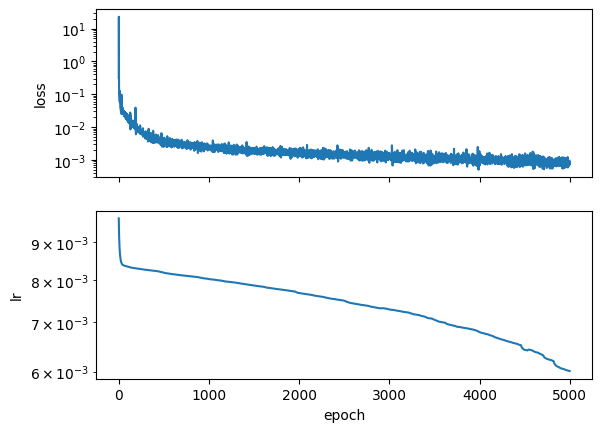

In [50]:
from typing import Callable, Iterable
from types import SimpleNamespace
import jax
from jax import numpy as jnp
from flax import linen as nn
import optax


class Model(nn.Module):
    sizes: Iterable[int]  # Number of hidden neurons
    nonlin: Callable

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        for size in self.sizes:
            x = nn.Dense(size)(x)
            x = self.nonlin(x)
        return nn.Dense(1)(x).flatten()


def train(config, x, y):
    x = jax.device_put(x)
    y = jax.device_put(y)
    model = Model(config.layers, config.nonlin)

    root_key = jax.random.PRNGKey(0)
    param_key, perm_key = jax.random.split(root_key)
    theta = model.init(param_key, x)

    opt = optax.inject_hyperparams(optax.rmsprop)(learning_rate=config.learning_rate)

    meta_opt = optax.adabelief(learning_rate=config.meta_learning_rate)

    state = opt.init(theta)
    eta = -np.log(1.0 / config.learning_rate - 1)
    meta_state = meta_opt.init(eta)

    @jax.jit
    def loss_fn(theta, x, y):
        def squared_error(x, y):
            y_pred = model.apply(theta, x)
            return jnp.square(y - y_pred)
        return jnp.mean(jax.vmap(squared_error, in_axes=0)(x, y))

    @jax.jit
    def step(theta, state, x, y):
        loss, grad = jax.value_and_grad(loss_fn)(theta, x, y)
        updates, state = opt.update(grad, state)
        theta = optax.apply_updates(theta, updates)
        return loss, theta, state

    @jax.jit
    def outer_loss(eta, theta, state, x, y):
        state.hyperparams["learning_rate"] = jax.nn.sigmoid(eta)
        loss, theta, state = step(theta, state, x[:-1], y[:-1])
        return loss_fn(theta, x[-1:], y[-1:]), (loss, theta, state)

    @jax.jit
    def outer_step(eta, theta, meta_state, state, x, y):
        grad, (loss, theta, state) = jax.grad(outer_loss, has_aux=True)(eta, theta, state, x, y)
        meta_updates, meta_state = meta_opt.update(grad, meta_state)
        eta = optax.apply_updates(eta, meta_updates)
        return eta, theta, meta_state, state, loss

    learning_rates = []
    losses = []

    for epoch in range(1, config.max_epoch + 1):
        perm_train_key = jax.random.fold_in(perm_key, epoch)
        perm = jax.random.permutation(perm_train_key, len(x))
        eta, theta, meta_state, state, loss = outer_step(eta, theta, meta_state, state, x[perm], y[perm])
        learning_rate = jax.nn.sigmoid(eta)

        losses.append(loss)
        learning_rates.append(learning_rate)

        if epoch == 1 or epoch % config.print_freq == 0:
            print(f"epoch {epoch} loss={loss} lr={learning_rate}")

    return model, theta, losses, learning_rates

config = SimpleNamespace()
config.layers = (2 ** 6,) * 4
config.nonlin = nn.relu
config.max_epoch = 5000
config.learning_rate = 1e-2
config.meta_learning_rate = 0.03
config.print_freq = 100

flax_model, flax_ml_theta, losses, learning_rates = train(config, X, y)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(losses)
ax[0].set(ylabel="loss", yscale="log")
ax[1].plot(learning_rates)
ax[1].set(xlabel="epoch", ylabel="lr", yscale="log");

In [48]:
print("MLPRegressor       ", mean_squared_error(clf.predict(X), y))
print("PyTorch            ", mean_squared_error(torch_model(torch_X).detach().numpy(), y))
print("Flax               ", mean_squared_error(flax_model.apply(flax_theta, X), y))
print("Flax: meta-learning", mean_squared_error(flax_model.apply(flax_ml_theta, X), y))

MLPRegressor        0.0010770992
PyTorch             0.00073587627
Flax                0.0005836923
Flax: meta-learning 0.0007888396


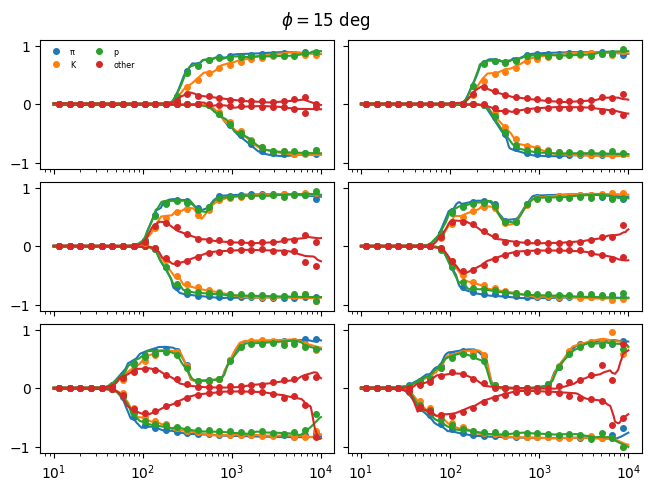

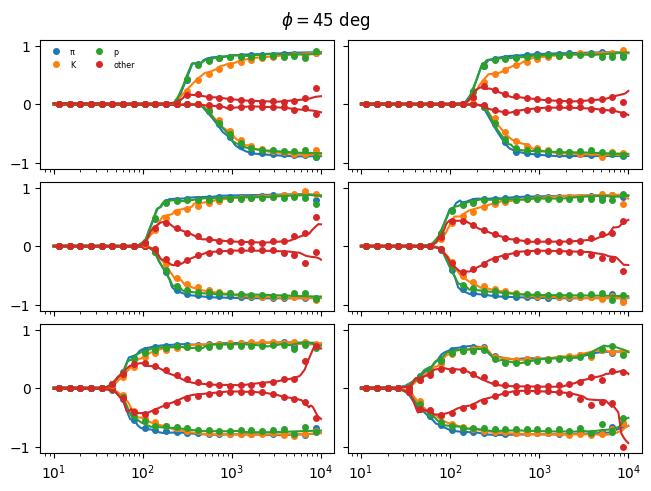

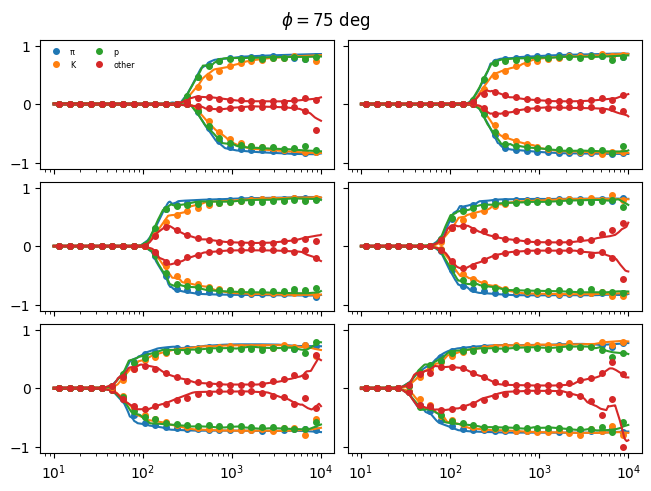

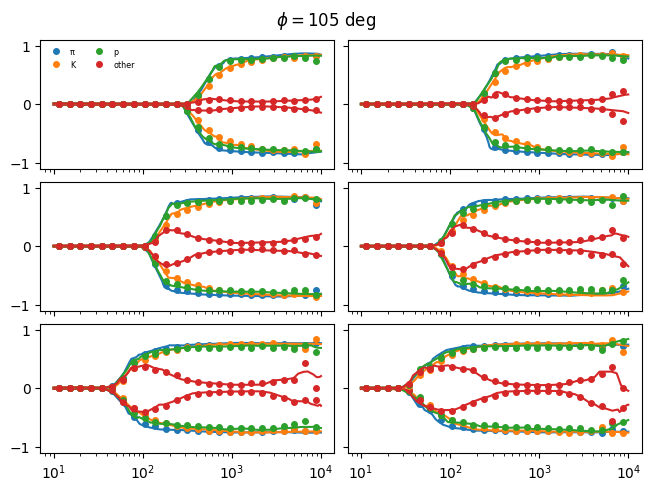

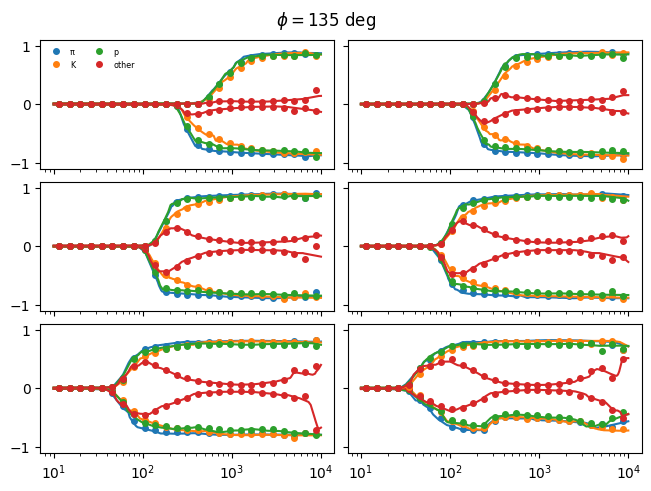

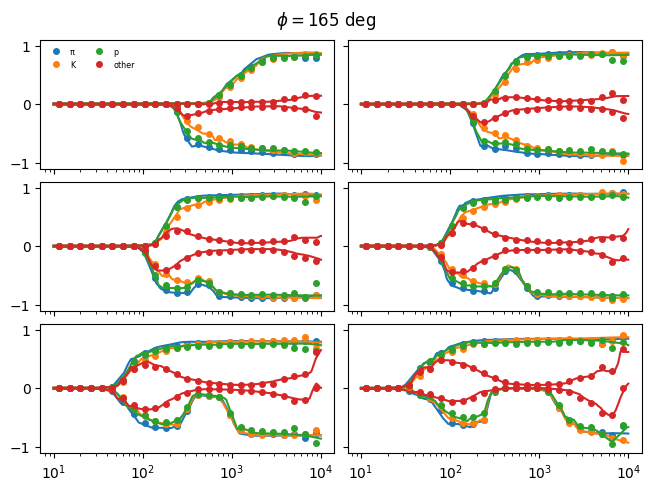

In [51]:
draw(lambda x: flax_model.apply(flax_ml_theta, x))

epoch 1 loss=8698.1416015625 lr=0.00970732606947422
epoch 100 loss=828.7393798828125 lr=0.0057868133299052715
epoch 200 loss=325.576171875 lr=0.004214224871248007
epoch 300 loss=314.3688659667969 lr=0.0032433480955660343
epoch 400 loss=39.32170867919922 lr=0.0022676156368106604
epoch 500 loss=47.09419250488281 lr=0.0021047245245426893
epoch 600 loss=20.751319885253906 lr=0.0017656871350482106
epoch 700 loss=75.92744445800781 lr=0.0015867415349930525
epoch 800 loss=25.746644973754883 lr=0.0014099696418270469
epoch 900 loss=70.89584350585938 lr=0.0012662906665354967
epoch 1000 loss=22.527172088623047 lr=0.0012305141426622868
epoch 1100 loss=20.766725540161133 lr=0.0011768920812755823
epoch 1200 loss=19.325674057006836 lr=0.0011517106322571635
epoch 1300 loss=19.198387145996094 lr=0.0011525456793606281
epoch 1400 loss=12.080772399902344 lr=0.0011121591087430716
epoch 1500 loss=22.5567684173584 lr=0.0010851438855752349
epoch 1600 loss=16.633529663085938 lr=0.0010508681880310178
epoch 1700 

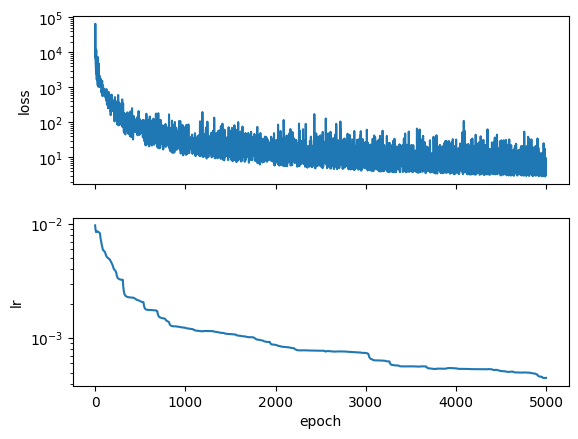

In [60]:
from typing import Callable, Iterable, Any
from types import SimpleNamespace
import jax
from jax import numpy as jnp
from flax import struct
from flax.core import FrozenDict
from flax import linen as nn
import optax


class Model(nn.Module):
    sizes: Iterable[int]  # Number of hidden neurons
    nonlin: Callable
    dropout_rate: float = 0.0

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x, train):
        for size in self.sizes:
            x = nn.Dense(size)(x)
            x = self.nonlin(x)
        x = nn.Dropout(rate=self.dropout_rate, deterministic=not train)(x)
        return nn.Dense(1, use_bias=False)(x).flatten()


class TrainState(struct.PyTreeNode):
    dropout_key: jax.Array
    params: FrozenDict[str, Any] = struct.field(pytree_node=True)
    opt_state: optax.OptState = struct.field(pytree_node=True)
    meta_params: float
    meta_opt_state: optax.OptState = struct.field(pytree_node=True)


def predict(model, theta, x):
    y = model.apply({"params": theta}, x, train=False)
    with np.errstate(over="ignore"):
        return 1 / (1 + np.exp(-y))


def train(config, x, k, n):
    x = jax.device_put(x)
    k = jax.device_put(k)
    n = jax.device_put(n)

    model = Model(config.layers, config.nonlin, config.dropout_rate)

    root_key = jax.random.PRNGKey(0)
    params_key, dropout_key, perm_key = jax.random.split(root_key, num=3)
    variables = model.init(params_key, x, train=False)

    opt = optax.inject_hyperparams(optax.rmsprop)(learning_rate=config.learning_rate)
    meta_opt = optax.adabelief(learning_rate=config.meta_learning_rate)
    eta = -np.log(1.0 / config.learning_rate - 1)

    state = TrainState(
        dropout_key=dropout_key,
        params=variables["params"],
        opt_state=opt.init(variables["params"]),
        meta_params=eta,
        meta_opt_state=meta_opt.init(eta),
    )

    @jax.jit
    def loss_fn(params, state, x, k, n):
        def fn(x, k, n):
            y = model.apply(
                {"params": params},
                x,
                train=True,
                rngs={"dropout": state.dropout_key},
            )
            p_sat = jnp.clip(k / (n + 1e-6), 1e-6, 1 - 1e-6)
            y_sat = jnp.log(p_sat / (1 - p_sat))
            l = k * (y - y_sat) - n * (
                jnp.log1p(jnp.exp(y)) - jnp.log1p(jnp.exp(y_sat))
            )
            return l
        l = jax.vmap(fn, in_axes=0)(x, k, n)
        return -2 * jnp.mean(l)

    @jax.jit
    def inner_step(state, x, k, n):
        loss, grad = jax.value_and_grad(loss_fn)(state.params, state, x, k, n)
        updates, opt_state = opt.update(grad, state.opt_state)
        params = optax.apply_updates(state.params, updates)
        state = state.replace(params=params, opt_state=opt_state)
        return loss, state

    @jax.jit
    def outer_loss(eta, state, x, k, n):
        state.opt_state.hyperparams["learning_rate"] = jax.nn.sigmoid(eta)
        loss, state = inner_step(state, x[:-1], k[:-1], n[:-1])
        return loss_fn(state.params, state, x[-1:], k[-1:], n[-1:]), (loss, state)

    @jax.jit
    def outer_step(state, x, k, n):
        grad, (loss, state) = jax.grad(outer_loss, has_aux=True)(
            state.meta_params, state, x, k, n
        )
        meta_updates, meta_opt_state = meta_opt.update(grad, state.meta_opt_state)
        meta_params = optax.apply_updates(state.meta_params, meta_updates)
        state = state.replace(meta_params=meta_params, meta_opt_state=meta_opt_state)
        return loss, state

    learning_rates = []
    losses = []

    for epoch in range(1, config.max_epoch + 1):
        perm_train_key = jax.random.fold_in(key=perm_key, data=epoch)
        state = state.replace(
            dropout_key=jax.random.fold_in(key=dropout_key, data=epoch),
        )
        perm = jax.random.permutation(perm_train_key, len(x))
        loss, state = outer_step(state, x[perm], k[perm], n[perm])
        learning_rate = jax.nn.sigmoid(state.meta_params)
        losses.append(loss)
        learning_rates.append(learning_rate)

        if epoch == 1 or epoch % config.print_freq == 0:
            print(f"epoch {epoch} loss={loss} lr={learning_rate}")

    return model, state.params, losses, learning_rates


config = SimpleNamespace()
config.layers = (2**6,) * 4
config.nonlin = nn.relu
config.dropout_rate = 0.01
config.max_epoch = 5000
config.learning_rate = 1e-2
config.meta_learning_rate = 0.03
config.print_freq = 100

flax_model_2, flax_theta_2, losses, learning_rates = train(config, X, data_k, data_n)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(losses)
ax[0].set(ylabel="loss", yscale="log")
ax[1].plot(learning_rates)
ax[1].set(xlabel="epoch", ylabel="lr", yscale="log");

In [61]:
print("MLPRegressor              ", mean_squared_error(clf.predict(X), y))
print("PyTorch                   ", mean_squared_error(torch_model(torch_X).detach().numpy(), y))
print("Flax                      ", mean_squared_error(flax_model.apply(flax_theta, X), y))
print(" + meta-learning          ", mean_squared_error(flax_model.apply(flax_ml_theta, X), y))
print(" + binomial loss, dropout ", mean_squared_error(predict(flax_model_2, flax_theta_2, X), y))

MLPRegressor               0.0010770992
PyTorch                    0.00073587627
Flax                       0.0005836923
 + meta-learning           0.0007262042
 + binomial loss, dropout  0.0010593749


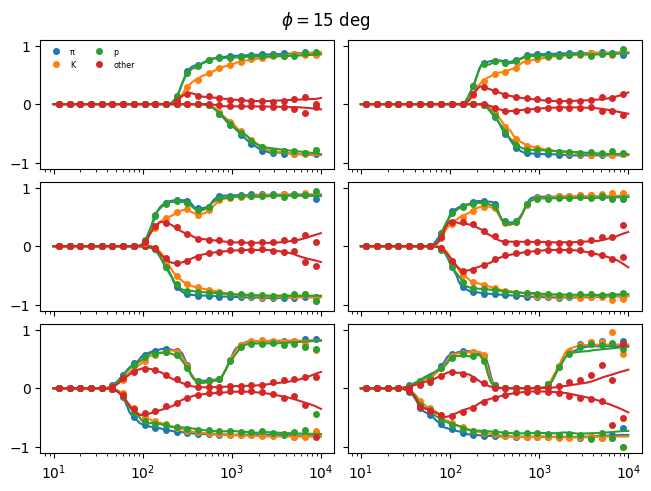

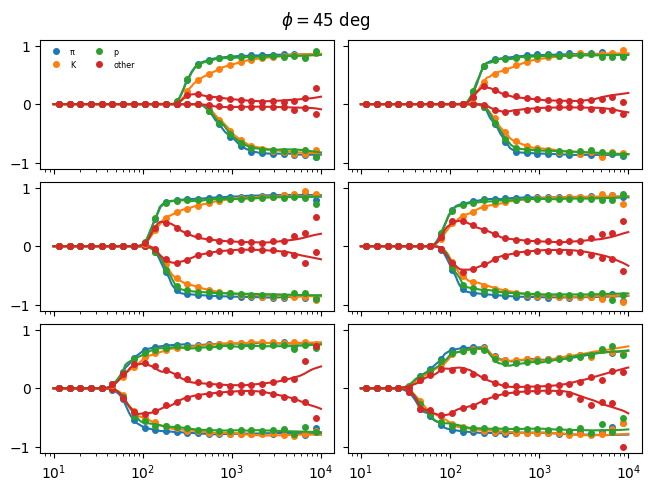

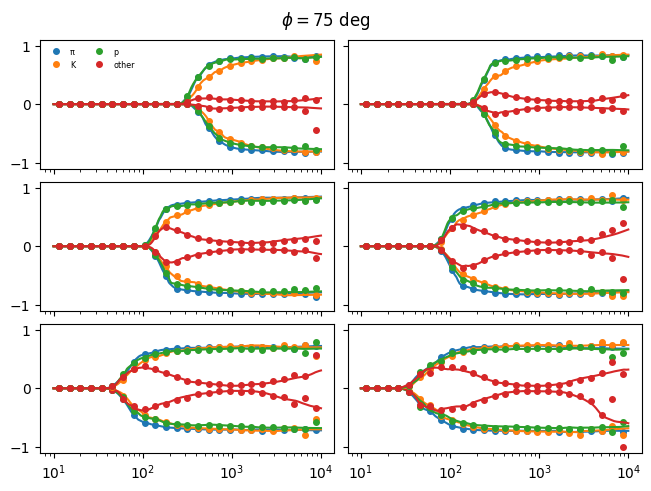

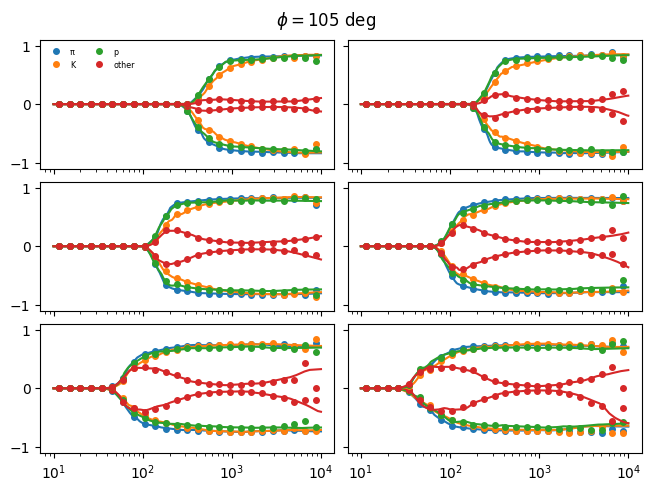

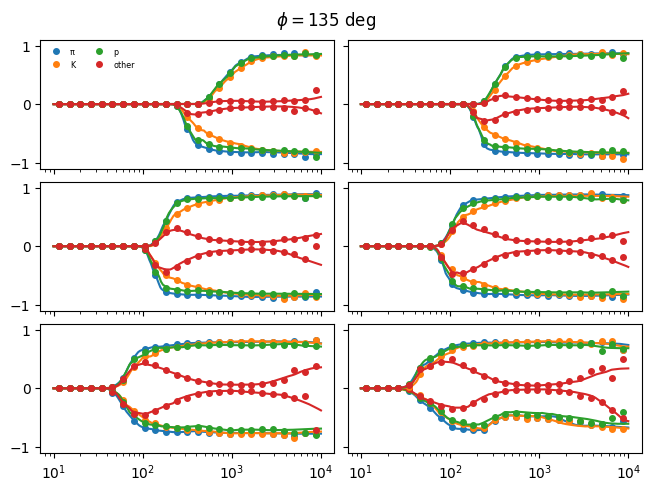

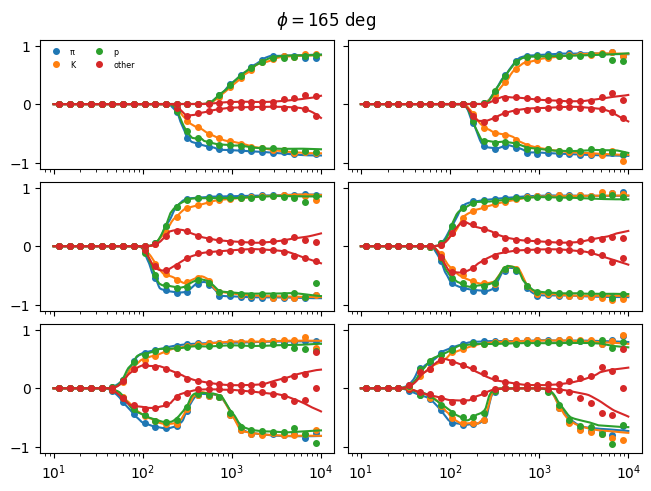

In [62]:
draw(lambda x: predict(flax_model_2, flax_theta_2, x))

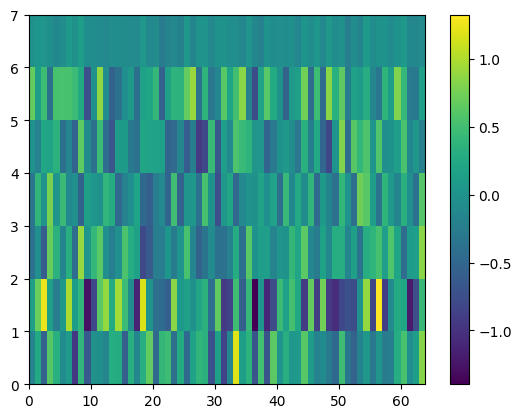

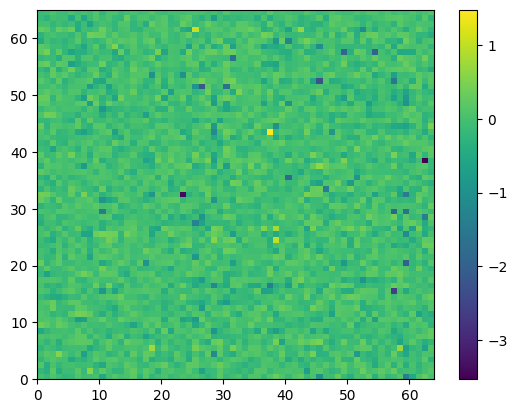

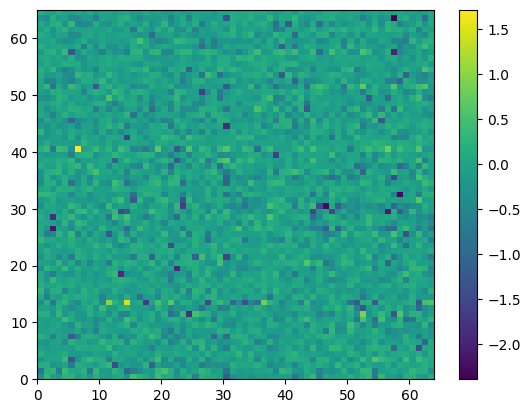

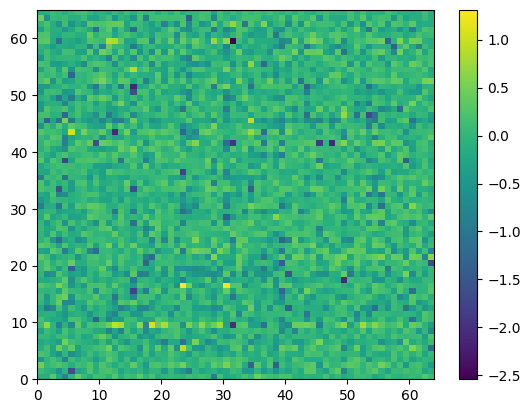

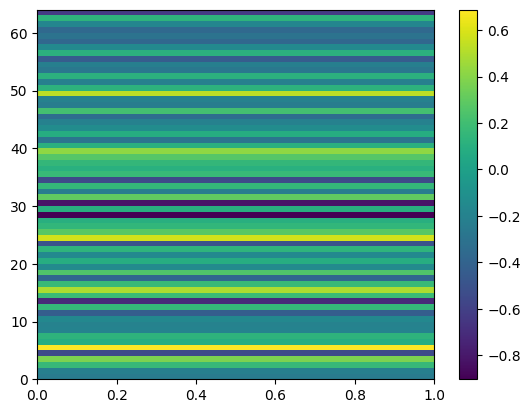

In [64]:
for layer in flax_theta_2.values():
    plt.figure()
    if "bias" in layer:
        plt.pcolormesh(np.row_stack((layer["kernel"], layer['bias'])))
    else:
        plt.pcolormesh(layer["kernel"])
    plt.colorbar()